# Peak fitting the Raman spectrum of Li$_2$Si$_4$O$_9$ glass

Code by Charles Le Losq, Created 7 April 2015 for Python, Modified 30 Sept. 2016 for Julia, updated February 2019, then April 2025.

Last modified: April 2025 for release of Spectra v2.0.0.

This code shows how to fit a Raman spectrum with Julia. Compared to previous versions, we will use the `fit_peaks` function that is now available in Spectra. We will leverage the quasi-Newton method. We use a loss function that takes into account of data and prior model errors. In other terms, we are setting ourselves in a Bayesian framework, where we put a prior on the model parameters. This is handy if you know well the value of some parameters, for instance from the litterature.

You could solve the following problem in a pure Bayesian approach, using e.g. HMC algorithm in Turing.jl. However, it takes some time... The quasi-Newton method is clean, the Julia code is the direct transcription of the mathematical formulas available in Tarantola ([2005](https://epubs.siam.org/doi/book/10.1137/1.9780898717921)), chapter 3. This method is fast, accurate, but sometime a bit instable. You can also use the BFGS method from Optim.jl, by setting the backend to `:Optim`. It is good, stable but slower.

In this example, we fit the 850-1300 cm$^{-1}$ portion of a Raman spectrum of a lithium tetrasilicate glass Li$_2$Si$_4$O$_9$, the name will be abbreviated LS4 in the following. 

For further references for fitting Raman spectra of glasses, please see for instance: 

- Virgo et al., 1980, Science 208, p 1371-1373; 
- Mysen et al., 1982, American Mineralogist 67, p 686-695; 
- McMillan, 1984, American Mineralogist 69, p 622-644; Mysen, 1990, American Mineralogist 75, p 120-134; 
- Le Losq et al., 2014, Geochimica et Cosmochimica Acta 126, p 495-517 
- Le Losq et al., 2015, Progress in Earth and Planetary Sciences 2:22.

`fit_peaks` is meant to fit a single spectrum. You could do a loop to fit several spectra, but if you want to define global models, I invite you to use the [JuMP framework](https://jump.dev/) or, if you fancy Bayesian MCMC methods, [Turing.jl](https://turinglang.org/index.html)


## Importing libraries and data

First part: we import the libraries for doing various things, and we import and have a look at the data. We will correct the data from temperature and excitation line effects using the `tlcorrection` function.

In [ ]:
using Revise
using Spectra, DelimitedFiles, Statistics

In [ ]:
using Plots
gr()

In [ ]:
using LaTeXStrings

In [ ]:
# get the spectrum to deconvolute, with skipping header and footer comment lines from the spectrometer
data = readdlm("./data/LS4.txt", '\t', Float64)

# To skip header and footer lines
skip_header = 23
skip_footer = 121
inputsp = zeros(size(data)[1]-skip_header-skip_footer,2)
j = 1
for i = skip_header+1:size(data)[1]-skip_footer
    inputsp[j,1] = Float64(data[i,1])
    inputsp[j,2] = Float64(data[i,2])
    j = j + 1
end

# performing the long correction; not always necessary at frequencies > 500 cm-1, 
# but this is just for the sack of example in the present case
x, y, ese_y = tlcorrection(inputsp, 23.0, 490.0)

# create a new plot for showing the spectrum
plot(x, y,
xlabel=L"Raman shift, cm$^{-1}$", 
ylabel="Normalized intensity, a. u.",
title="Figure 1: the spectrum of interest")

So we are looking at the 500-1300 cm$^{-1}$ portion of the Raman spectrum of the glass. We see a peak near 800 cm$^{-1}$, and two others near 950 and 1085 cm$^{-1}$. We will be interested in fitting the 870-1300 cm$^{-1}$ portion of this spectrum, which can be assigned to the various symmetric and assymetric stretching vibrations of Si-O bonds in the SiO$_2$ tetrahedra present in the glass network (see the above cited litterature for details).

## Baseline Removal

First thing we notice in Fig. 1, we have to remove a baseline because this spectrum is shifted from 0 by some "background" scattering. This quite typical in Raman spectra of glasses. Several ways exist to do so. We're going to the simplest thing: a polynomial fitting the signal base around 870 and 1300 cm$^{-1}$. Other reasonnable solutions include a linear function, and a constant function. The two latter can be fitted between 1300 and 1350 cm$^{-1}$, but we will need to add another peak around 800 cm$^{-1}$. For now, the example is done with fitting the 870 cm$^{-1}$ portion of spectra, as this usually results in more robust final results.


In [8]:
# the regions of interest roi
roi = [860.0 870.0; 1300.0 1400.0]

y_corr, y_bas = baseline(x, y, roi=roi, method="polynomial", polynomial_order=2) 

#Creates a plot showing the baseline
plot(x, [y y_corr y_bas],
xlabel=L"Raman shift, cm$^{-1}$", 
ylabel="Normalized intensity, a. u.",
title="Figure 2: the fit of the background")

                                   Figure 2: the fit of the background      
                               +----------------------------------------+   
                    0.00421998 |                         r.             | y1
                               |                        |.|             | y2
                               |                        /^|             | y3
                               |                        ] @             |   
                               |                       ,[ ].            |   
                               |                       /| ||            |   
                               |                       @  "1            |   
   Normalized intensity, a. u. | T,                   ||   V.           |   
                               |  \,                 .^`   ,\           |   
                               |   \_             .. //    "V,          |   
                               | -, "-.   ._.    .,'-,`     ,\,         |   

Now we will do some manipulation to have the interested portion of spectrum in a single variable, using `extract_signal`. We will calculate the errors based on the comparison between the signal and its "smoothed version".

In [12]:
## First we extract the signal we want to fit
x_fit, y_fit, _ = extract_signal(x, y_corr, [860. 1300.])

## We normalise y_fit so that its maximum is 1
y_fit = normalise(y_fit; x=x_fit, method="area")

## We smoothed the signal and get an estimate of the errors using it.
y_fit_perfect = smooth(x_fit, y_fit, method="whittaker", lambda=1e2)
ese_y_fit = sqrt.(mean((y_fit_perfect-y_fit).^2)) * ones(size(y_fit_perfect))

## We transform our X axis so that the X values, like the Y values, vary between 0 and 1
x_fit_min = minimum(x_fit)
x_fit_max = maximum(x_fit)
x_fit_scaled = (x_fit .- x_fit_min)./(x_fit_max.-x_fit_min)

## Let's have a look at the signal in the fitting region
plot(x_fit_scaled, y_fit, label="Signal to fit")
plot!(x_fit_scaled, y_fit_perfect, label="smoothed",
    xlabel=L"Raman shift, cm$^{-1}$", 
    ylabel="Normalized intensity, a. u.",
    title="Figure 3: signal to peak fit")

                                      Figure 3: signal to peak fit                     
                               +----------------------------------------+              
                     0.0083241 | |                 ,-                   | Signal to fit
                               | |                .| \                  | smoothed     
                               | |                /  ,                  |              
                               | |               .|  "|                 |              
                               | |               /    l                 |              
                               | |              .|    |.                |              
                               | |              /      \                |              
   Normalized intensity, a. u. | |             ,`      |.               |              
                               | |            ./        \               |              
                               |

# Fitting the spectrum

We do the fit using the `fit_peaks` function with the quasi-Newton algorithm. From the litterature, we have five peaks (see Le Losq et al. 2014, 2015 and references therein). Compared to earlier studies, we also now know that the main one near 1080 cm$^-1$ may be actually a pseudovoigt peak. 

Here we will place a strong prior on the intensity of the peak near 1090 cm-1. It seems even a bit unrealistic but the influence of the prior loss compared to the data loss is somehow small.


Let's implement that in a `peaks_info` vector of peak parameters, uncertainties and boundaries. 

Then we declare the context and have a look at the prior mode. If necessary we re-adjust it. Keep in mind that it should be fairly close to the solution, as the algorithms (here the quasi-Newton method) we use are local search algorithms.

In [10]:
peaks_info = [
        # (type, initial_params, uncertainties, lower_bounds, upper_bounds)
        (:gaussian,    [0.002, 950, 27],       [0.0005, 5.0,3.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
        (:gaussian,    [0.0044, 1044, 40],      [0.0005, 5.0, 3.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
        (:pseudovoigt,   [0.0093, 1086, 30., 0.8], [0.0001, 5.0, 3.0, 0.02], [0.0, 0.0, 0.0, 0.0], [Inf, Inf, 60.0, 1.0]),
        #(:gaussian,   [0.88, 1086, 27],       [0.01, 2.0, 2.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
        (:gaussian,    [0.0028, 1150, 45],      [0.0005, 5.0, 3.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
        (:gaussian,    [0.0009, 1185, 30],      [0.0001, 5.0, 3.0], [0.0, 0.0, 0.0], [Inf, Inf, 60.0]),
    ]
## we declare the context
ctx = prepare_context(x_fit, y_fit, peaks_info, ese_y_fit)

## We plot the prior model, and 
p = plot_fit(ctx)
display(p)

No result provided, plotting the prior...


                             Model adjustement                          
                +----------------------------------------+              
      0.0124576 |                   ,-                   | Data         
                |                   ,"|                  | Prior model  
                |                  |` .                  | Gaussian 1   
                |                  , _|.                 | Gaussian 2   
                |                 /`|"\\                 | PseudoVoigt 3
                |                .| ⚬⚬⚬,                 | Gaussian 4   
                |                / ⚬⚬ ⚬,|                | Gaussian 5   
              Y |               |`⚬⚬   ⚬,.               |              
                |              .|⚬⚬|   ⚬⚬\.              |              
                |              /⚬⚬{.    ⚬ '\,.           |              
                |             /⚬⚬.,\,   ⚬⚬   \,          |              
                |        ___./⚬⚬ /  \,  .⚬⚬⚬,.\,   

In [11]:
## doing the fit
@time result = fit_peaks(ctx, backend=:Optim, relax=5, maxiter=20)

## we print the result using
print_params(result.peak_results)

## and we plot the fit
plot_fit(ctx, result.peak_results)

 20.126545 seconds (25.49 M allocations: 4.608 GiB, 7.28% gc time, 77.68% compilation time)
Peak 1 (gaussian):
  amplitude: 0.0015223 ± 2.0e-6
  center: 945.428 ± 0.019
  width: 24.891 ± 0.024
  area: 0.08067 ± 0.00016
Peak 2 (gaussian):
  amplitude: 0.004102 ± 2.5e-5
  center: 1061.59 ± 0.49
  width: 58.45 ± 0.26
  area: 0.5104 ± 0.0053
Peak 3 (pseudovoigt):
  amplitude: 0.004283 ± 3.8e-5
  center: 1086.1 ± 0.042
  width: 28.193 ± 0.065
  fraction: 0.2832 ± 0.004
  area: 0.2917 ± 0.0031
Peak 4 (gaussian):
  amplitude: 0.000904 ± 3.4e-5
  center: 1140.67 ± 0.39
  width: 30.3 ± 0.36
  area: 0.0583 ± 0.0028
Peak 5 (gaussian):
  amplitude: 0.000819 ± 1.8e-5
  center: 1185.54 ± 0.91
  width: 39.29 ± 0.37
  area: 0.0685 ± 0.0021


                              Model adjustement                           
                 +----------------------------------------+               
       0.0083241 |                   ⚬⚬                   | Data          
                 |                  ⚬⚬"⚬                  | Adjusted model
                 |                  ⚬  ⚬                  | Gaussian 1    
                 |                 ⚬⚬  ⚬⚬                 | Gaussian 2    
                 |                 ⚬    ⚬                 | PseudoVoigt 3 
                 |                ⚬⚬    ⚬⚬                | Gaussian 4    
                 |                ⚬      ⚬                | Gaussian 5    
               Y |               ⚬⚬r-v"| ⚬⚬               |               
                 |              ⚬⚬/ .,\]. ⚬               |               
                 |              ⚬/  .  \\ ⚬⚬              |               
                 |             ⚬⚬   ,   |, ⚬⚬             |               
                 |       

In [9]:
result.peak_results

5-element Vector{Any}:
 (peak_type = :gaussian, params = Measurements.Measurement{Float64}[0.0015223 ± 2.0e-6, 945.428 ± 0.019, 24.891 ± 0.024], area = 0.08067 ± 0.00016)
 (peak_type = :gaussian, params = Measurements.Measurement{Float64}[0.004102 ± 2.5e-5, 1061.59 ± 0.49, 58.45 ± 0.26], area = 0.5104 ± 0.0053)
 (peak_type = :pseudovoigt, params = Measurements.Measurement{Float64}[0.004283 ± 3.8e-5, 1086.1 ± 0.042, 28.193 ± 0.065, 0.2832 ± 0.004], area = 0.2917 ± 0.0031)
 (peak_type = :gaussian, params = Measurements.Measurement{Float64}[0.000904 ± 3.4e-5, 1140.67 ± 0.39, 30.3 ± 0.36], area = 0.0583 ± 0.0028)
 (peak_type = :gaussian, params = Measurements.Measurement{Float64}[0.000819 ± 1.8e-5, 1185.54 ± 0.91, 39.29 ± 0.37], area = 0.0685 ± 0.0021)

  3.181185 seconds (4.64 M allocations: 671.186 MiB, 4.54% gc time, 64.07% compilation time)
Peak 1 (gaussian):
  amplitude: 0.0015223 ± 2.7e-6
  center: 945.428 ± 0.024
  width: 24.891 ± 0.029
  area: 0.08067 ± 0.00022
Peak 2 (gaussian):
  amplitude: 0.004102 ± 3.8e-5
  center: 1061.59 ± 0.73
  width: 58.45 ± 0.4
  area: 0.5104 ± 0.0081
Peak 3 (pseudovoigt):
  amplitude: 0.004283 ± 5.5e-5
  center: 1086.1 ± 0.038
  width: 28.193 ± 0.083
  fraction: 0.2832 ± 0.0043
  area: 0.2917 ± 0.0044
Peak 4 (gaussian):
  amplitude: 0.000904 ± 5.3e-5
  center: 1140.67 ± 0.4
  width: 30.3 ± 0.4
  area: 0.0583 ± 0.0041
Peak 5 (gaussian):
  amplitude: 0.000819 ± 1.4e-5
  center: 1185.54 ± 0.77
  width: 39.29 ± 0.35
  area: 0.0685 ± 0.0017


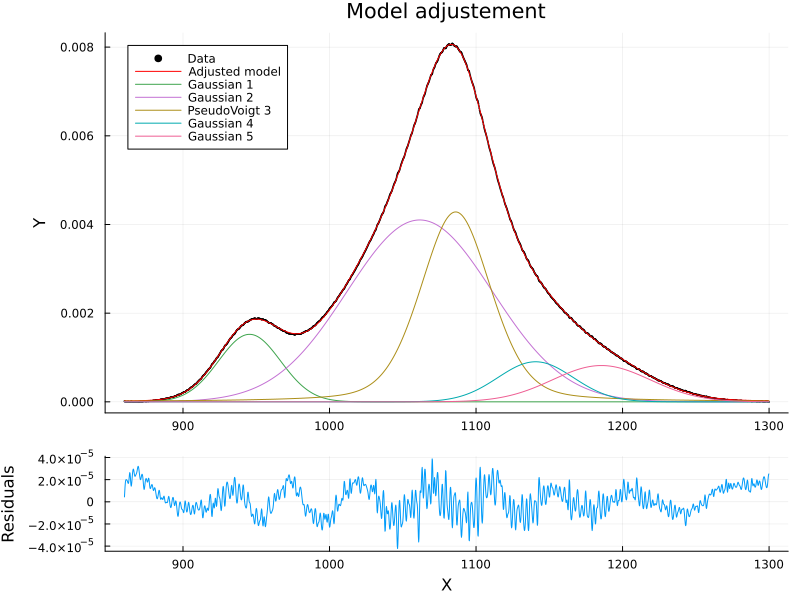

In [11]:
## doing the fit
@time result = fit_peaks(ctx, backend=:qGN, relax=5, maxiter=100)

## we print the result using
print_params(result.peak_results)

## and we plot the fit
plot_fit(ctx, result.peak_results)

## Checking errors with bootstrapping

The error bars above appear fairly small... We check them using boostrapping. Again, we use a unrealistically low number of bootstrapped samples here because this code runs during documentation generation, but in reality you would like to increase `nb_boot` to something like 1000. I also fidled with `maxiter` to set it to a small value while still seeing convergence, such that we don't spend too much time in the quasi-Newton algorithm.

In [12]:
boot_samples, boot_results = bootstrap(x_fit, y_fit, ese_y_fit, peaks_info, nb_boot = 50, backend=:qGN, relax=5., maxiter=20)


([0.0015180378545586297 0.0015232844039342283 … 0.001522538723485895 0.0015196382591653795; 945.4282668381334 945.4364056982075 … 945.4998988598039 945.4157093279354; … ; 1190.975924531925 1191.0536145249405 … 1190.879887240852 1189.3101384191682; 37.2789653869798 37.3534910220048 … 37.456718323633005 37.75017022184032], Any[(peak_type = :gaussian, params = Measurements.Measurement{Float64}[0.0015225 ± 2.4e-6, 945.448 ± 0.025, 24.902 ± 0.032], area = 0.08071 ± 0.00018), (peak_type = :gaussian, params = Measurements.Measurement{Float64}[0.004245 ± 3.2e-5, 1063.89 ± 0.55, 59.41 ± 0.26], area = 0.5369 ± 0.0063), (peak_type = :pseudovoigt, params = Measurements.Measurement{Float64}[0.004113 ± 4.7e-5, 1085.835 ± 0.068, 27.82 ± 0.1, 0.315 ± 0.0063], area = 0.2801 ± 0.004), (peak_type = :gaussian, params = Measurements.Measurement{Float64}[0.000895 ± 3.5e-5, 1143.4 ± 0.84, 32.23 ± 0.65], area = 0.0614 ± 0.0033), (peak_type = :gaussian, params = Measurements.Measurement{Float64}[0.000729 ± 3.3

Peak 1 (gaussian):
  amplitude: 0.0015225 ± 2.4e-6
  center: 945.448 ± 0.025
  width: 24.902 ± 0.032
  area: 0.08071 ± 0.00018
Peak 2 (gaussian):
  amplitude: 0.004245 ± 3.2e-5
  center: 1063.89 ± 0.55
  width: 59.41 ± 0.26
  area: 0.5369 ± 0.0063
Peak 3 (pseudovoigt):
  amplitude: 0.004113 ± 4.7e-5
  center: 1085.835 ± 0.068
  width: 27.82 ± 0.1
  fraction: 0.315 ± 0.0063
  area: 0.2801 ± 0.004
Peak 4 (gaussian):
  amplitude: 0.000895 ± 3.5e-5
  center: 1143.4 ± 0.84
  width: 32.23 ± 0.65
  area: 0.0614 ± 0.0033
Peak 5 (gaussian):
  amplitude: 0.000729 ± 3.3e-5
  center: 1189.9 ± 1.5
  width: 37.7 ± 0.49
  area: 0.0585 ± 0.0034


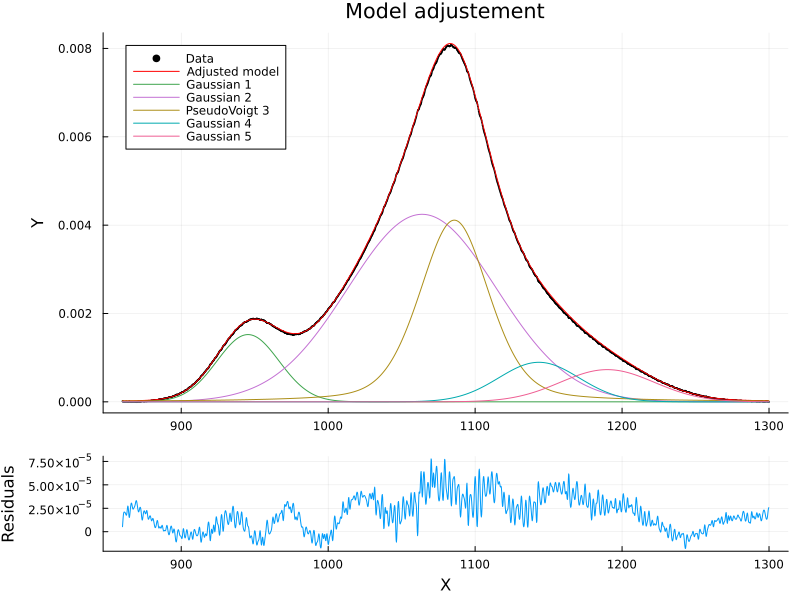

In [14]:
# We can now print the bootstrapped results and compare the errors with those
# previously calculated from the Hessian:
print_params(boot_results)

# OK, actually for this example, we see that the errors from the boostrap analysis
# are close to those calculated from the Hessian matrix. Everything thus seems OK.
#
# Of course, a final quick visual inspection is always nice. This can be done by passing the 
# median of the matrix of bootstrapped parameters to the plot_fit function
plot_fit(ctx, boot_results)

In [18]:
Statistics.cov(boot_params, dims=2)

16×16 Matrix{Float64}:
  6.61219e-12   4.70463e-8    7.44496e-8   …  -2.07503e-6   8.99547e-7
  4.70463e-8    0.000843798   0.000877288     -0.00844417   0.0031017
  7.44496e-8    0.000877288   0.00115563      -0.026455     0.010557
 -4.06256e-11  -1.33163e-7   -3.38378e-7       2.35124e-6  -1.29995e-6
 -1.14941e-6   -0.00568797   -0.0115992        0.248331    -0.109428
 -6.74872e-7   -0.00410502   -0.00746706   …   0.17967     -0.0770361
  6.63921e-11   2.88787e-7    6.5426e-7       -1.27721e-5   5.2682e-6
  1.02706e-7    0.000787264   0.00146307      -0.0561039    0.0206361
  5.25723e-8   -8.93187e-6    0.000317816      0.00847544  -0.00381303
 -1.73722e-8   -0.000113322  -0.000204751      0.00674233  -0.00294397
  3.7253e-11    2.90302e-7    2.8506e-7    …   2.00246e-5  -7.07613e-6
 -1.68727e-6   -0.00798479   -0.0196387        0.95432     -0.392819
 -2.61084e-7   -0.00241908   -0.00638616       0.527495    -0.190157
  4.70755e-11   2.46678e-7    6.244e-7        -3.51484e-5   1.3816

In [21]:
result.covariance

16×16 Matrix{Float64}:
  7.46871e-12   5.56187e-8    5.93446e-8   …  -3.53836e-9  -8.63905e-8
  5.56187e-8    0.000593226   0.000537737      0.00146095  -0.00137883
  5.93446e-8    0.000537737   0.00082174      -0.00164039   0.000328577
 -8.15035e-11  -6.37112e-7   -5.4256e-7       -5.11928e-6   4.36913e-6
 -1.76643e-6   -0.0136363    -0.013059        -0.0666011    0.0666711
 -9.94066e-7   -0.00781401   -0.00781511   …  -0.0316895    0.0327954
  1.2227e-10    9.47722e-7    8.43848e-7       4.58024e-6  -5.11114e-6
  5.76916e-8    0.000414446   0.000442722     -0.0127106    0.00360971
  1.34976e-7    0.00105811    0.000689431      0.00842355  -0.00900244
 -7.19331e-9   -4.13093e-5   -7.66787e-5       0.00137989  -0.000622477
  1.15971e-10   9.37787e-7    8.5174e-7    …   1.97856e-5  -1.09497e-5
 -8.67644e-7   -0.00629677   -0.00762119       0.154188    -0.0554654
  6.51626e-7    0.00564615    0.0048712        0.227112    -0.106246
  1.10861e-11   5.69487e-8    1.15814e-7      -1.02168e-5

In [148]:
# for Bayesian peak fitting example
using Turing

# Define a Bayesian model with priors
@model function bayesian_peaks(x, y)
    # Define priors based on peak_types
    
    # PEAK 1
    amplitude ~ truncated(Normal(0.16, 0.05), 0.0, Inf)
    center ~ Normal(946.0, 2.0)
    width ~ truncated(Normal(25.5, 2.0), 0.0, Inf)
    
    μ = gaussian(x, [amplitude, center, width])
    
    # PEAK 2
    amplitude2 ~ truncated(Normal(0.29, 0.5), 0.0, Inf)
    center2 ~ Normal(1036.7, 0.5)
    width2 ~ truncated(Normal(44.1, 0.5), 0.0, Inf)
    
    μ2 = gaussian(x, [amplitude2, center2, width2])
    
    # PEAK 3
    amplitude3 ~ truncated(Normal(0.66, 0.5), 0.0, Inf)
    center3 ~ Normal(1086.0, 2.0)
    width3 ~ truncated(Normal(31.6, 0.5), 0.0, Inf)
    lr ~ truncated(Normal(0.8, 0.03), 0.0, 1.0)
    
    μ3 = pseudovoigt(x, [amplitude3, center3, width3, lr])
    
    # PEAK 4
    amplitude4 ~ truncated(Normal(0.13, 0.05), 0.0, Inf)
    center4 ~ Normal(1140.0, 2.0)
    width4 ~ truncated(Normal(28.0, 1.0), 0.0, Inf)
    
    μ4 = gaussian(x, [amplitude4, center4, width4])
    
    # PEAK 5
    amplitude5 ~ truncated(Normal(0.09, 0.5), 0.0, Inf)
    center5 ~ Normal(1182.25, 10.0)
    width5 ~ truncated(Normal(38.95, 0.5), 0.0, Inf)
    
    μ5 = gaussian(x, [amplitude5, center5, width5])
    
    # Likelihood
    σ ~ truncated(Normal(0.002, 0.001), 0.0001, Inf)
    y ~ MvNormal(μ + μ2 + μ3 + μ4 + μ5, σ^2 * I)
end

#chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 2000, nchains=3, progress=true)

bayesian_peaks (generic function with 2 methods)

In [149]:
md_ = bayesian_peaks(x_fit, y_fit)
map_estimate = maximum_a_posteriori(md_)

ModeResult with maximized lp of 10871.79
[0.1595738825391328, 946.1017383360859, 25.408602155883607, 0.3216937281947708, 1042.7234396370513, 47.72814998413976, 0.6004510282300478, 1086.635902686329, 30.516477881684906, 0.21738148856437053, 0.14209840151400113, 1137.8768523237443, 29.766069166984227, 0.0930531877642551, 1181.9732692210541, 39.59987496984923, 0.0015141123424754705]

In [150]:
chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 1000, 
nchains=3, progress=true; initial_params=map_estimate.values.array)


┌ Info: Found initial step size
└   ϵ = 9.765625e-5
Sampling: 100%|█████████████████████████████████████████| Time: 0:18:33


Chains MCMC chain (1000×29×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 1130.54 seconds
Compute duration  = 1130.54 seconds
parameters        = amplitude, center, width, amplitude2, center2, width2, amplitude3, center3, width3, lr, amplitude4, center4, width4, amplitude5, center5, width5, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters        mean       std      mcse   ess_bulk   ess_tail      rhat   ⋯
      Symbol     Float64   Float64   Float64    Float64    Float64   Float64   ⋯

   amplitude      0.1596    0.0003    0.0000   739.5881   647.5355    0.9995   ⋯
      center    946.1054    0.0433    0.0017   658.8188   626.8269    1.0016   ⋯
       width     25.4121    0.0458    0.0016   843.8997   704.7460    0.9992   ⋯
  

In [157]:
result.print_params(digits=4)

Peak 1 (gaussian):
  amplitude: 0.1622 ± 0.0001
  center: 946.4133 ± 0.0198
  width: 25.5872 ± 0.022
Peak 2 (gaussian):
  amplitude: 0.294 ± 0.0005
  center: 1036.7423 ± 0.0919
  width: 44.1413 ± 0.0724
Peak 3 (pseudovoigt):
  amplitude: 0.6651 ± 0.0009
  center: 1086.6385 ± 0.0231
  width: 31.662 ± 0.0269
  fraction: 0.1947 ± 0.0021
Peak 4 (gaussian):
  amplitude: 0.1343 ± 0.0013
  center: 1140.2145 ± 0.0923
  width: 28.1513 ± 0.1206
Peak 5 (gaussian):
  amplitude: 0.0941 ± 0.0008
  center: 1182.2585 ± 0.3612
  width: 38.9521 ± 0.163


The estimated mean standard error on y_obs is 0.26
Peak 1 (gaussian):
  amplitude: 10.027 ± 0.055
  center: 34.954 ± 0.087
  width: 9.841 ± 0.09
  area: 210.1 ± 2.5
Peak 2 (lorentzian):
  amplitude: 14.868 ± 0.08
  center: 54.968 ± 0.017
  width: 3.063 ± 0.029
  area: 143.1 ± 1.2
Peak 3 (pearson7):
  amplitude: 20.05 ± 0.15
  center: 44.987 ± 0.011
  width: 2.022 ± 0.038
  exponent: 0.4039 ± 0.0037
  area: -170.0 ± 12.0
Peak 1 (gaussian):
  amplitude: 10.027 ± 0.055
  center: 34.954 ± 0.086
  width: 9.841 ± 0.089
  area: 210.1 ± 2.5
Peak 2 (lorentzian):
  amplitude: 14.868 ± 0.08
  center: 54.968 ± 0.017
  width: 3.063 ± 0.029
  area: 143.1 ± 1.2
Peak 3 (pearson7):
  amplitude: 20.05 ± 0.15
  center: 44.987 ± 0.011
  width: 2.022 ± 0.038
  exponent: 0.4039 ± 0.0037
  area: -170.0 ± 12.0
Peak 1 (gaussian):
  amplitude: 10.01 ± 0.055
  center: 34.915 ± 0.097
  width: 9.87 ± 0.1
  area: 210.4 ± 2.7
Peak 2 (lorentzian):
  amplitude: 14.878 ± 0.076
  center: 54.958 ± 0.02
  width: 3.063 ± 0

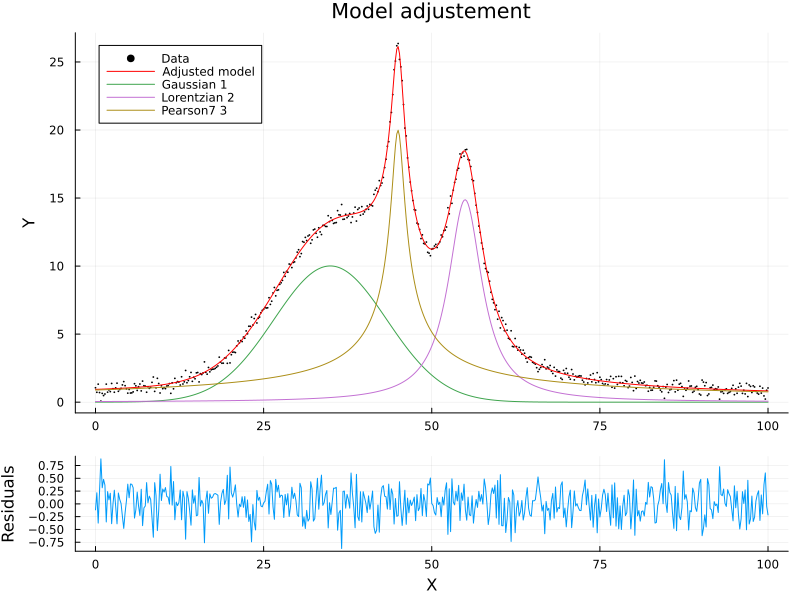

In [18]:
# # Peak fitting
# 
# Charles Le Losq, May 2017; Updated January 2024, April 2025
# 
# In the new version, we showcase the use of the `fit_peaks` function and then show also how you can solve the problem with Turing.jl and JuMP too. Running the notebook entirely thus requires you to have those installed, but if you want to stop at the `fit_peaks` function, you can skip the cells related to Turing.jl and JuMP!
# 
# ## Generating data
# 
# We generate three peaks using Spectra's functions:
# 
using Plots, Spectra, StatsBase

## The X axis
x = collect(0:0.2:100)
## The "perfect" Y signal
y_perfect = (
    gaussian(x, [10.0, 35.0, 10.0]) +
    lorentzian(x, [15.0, 55.0, 3.0]) +
    pearson7(x, [20.0, 45.0, 2.0, 0.4])
)
## Of course, in real world we have noise, here it is Gaussian
noise = randn(length(x))*0.3

## This is what we observe and want to fit
y_obs = y_perfect + noise

## Let's visualize it!
p1 = plot(x, [y_perfect, y_obs]; labels=["The true signal" "Observations"])
#savefig("fit_1.svg"); nothing #hide
# ![](fit_1.svg)

# ## Declaring peak informations
#
# In the real world, we see only the above figure. 
# We guess peak positions and shapes based on the visual inspection. 
# So we start with prior estimates on peak parameters based on this visual inspection. 
# Data from publications can bring further insights. This helps e.g. constraining the position of 
# some peaks, and `Spectra.fit_peaks` leverages such information via an *à priori* vector of 
# peak parameter uncertainties (1-sigma).
# 
# Another option is available : you can place lower and upper bounds on parameter values. 
# This is very useful if your parameters cannot take some values: e.g. hwhm should be positive 
# and lorentzian_fraction should be comprised between 0 and 1.
# 
# All this is indicated as follow:

peaks_info = [
    ## (peak_type, initial_params, params_uncertainties, lower_bounds, upper_bounds)
    (   
        :gaussian, ## peak_type
        [10.5, 30.0, 11.0], ## initial_params > prior model
        [5.0, 5.0, 3.0], ## params_uncertainties  > prior model uncertainties
        [0.0, 0.0, 0.0], ## lower_bounds
        [Inf, Inf, 50.0]), ## upper_bounds
    (
        :lorentzian, ## peak_type
        [17.5, 54.0, 3.1], ## initial_params > prior model
        [5.0, 3.0, 1.0], ## params_uncertainties > prior model uncertainties
        [0.0, 0.0, 0.0], ## lower_bounds
        [Inf, Inf, Inf], ## upper_bounds
    ),
    (
        :pearson7, ## peak_type
        [21.5, 44.0, 3.0, 0.4], ## initial_params > prior model
        [3.0, 2.0, 5.0, 0.02], ## params_uncertainties > prior model uncertainties
        [0.0, 0.0, 0.0, 0.0], ## lower_bounds
        [100.0, 100.0, 50.0, Inf], ## upper_bounds
    ),
]

# ## Error on the data?
#
# Usually we also do not have a precise idea of the errors that affect y. A good approximation 
# can be to simply smooth the signal, and calculate the errors using the smoothed signal and the observed one.
# Let's also do that here and check that it yields a fairly good approximation of the true error (should be around 0.3)

y_smo = smooth(x, y_obs, method="gcvspline");
estimated_mean_error = sqrt(mean((y_obs .- y_smo).^2))
println("The estimated mean standard error on y_obs is $(round(estimated_mean_error,digits=2))")

# OK, the result seems to be not too bad. We will place ourselves in a "real world" situation and 
# use those errors. For convenience we create an vector of errors

estimated_error = estimated_mean_error * ones(size(x));

# ## Fitting
#
# We use now the `fit_peaks` function to perform the fit.
# 
# This function returns a Named Tuple with various fields (see documentation).
# 
# First, we need to create the Julia object that contains all the context of the fit, 
# including the data, priors, peak informations...

ctx = prepare_context(x, y_obs, peaks_info, estimated_error)

# We launch the fit using the quasi-Newton algorithm implemented in Spectra. 
# This algorithm assumes that everything is Gaussian: the distributions
# of parameter and data errors are assumed to be Gaussian, and we also
# assume that the problem is nearly linear near the optimal point. In practice, 
# this algorithm works well and has the advantage of leveraging the prior information provided
# in `peaks_info`.
# The downside is sometimes some numerical instability: when `relax`is too low, DomainError is raised because 
# complex numbers appear in the Hessian matrix and mess with the sqrt() function. The fit is thus not good.
# In this case, increase relax to make smaller optimization steps, and also 
# maxiter to allow more iterations for convergence.

result = fit_peaks(ctx, backend=:qGN, relax=5)

## we print the result using
print_params(result.peak_results)

## and we plot the fit
plot_fit(ctx, result.peak_results)
#savefig("fit_2.svg"); nothing #hide
# ![](fit_2.svg)

# You could also use the Optim backend, which uses a constrained L-BFGS-B search algorithm. 
# Therefore, in addition to using the prior uncertainties, 
# this backend leverages the lower and upper boundaries 
# declared earlier in `peaks_info`: 

result = fit_peaks(ctx, backend=:Optim)
print_params(result.peak_results)
plot_fit(ctx, result.peak_results)
#savefig("fit_3.svg"); nothing #hide
# ![](fit_3.svg)

# ## Checking errors with bootstrapping
# The errors provided above come from the Hessian matrix at the optimal point.
# Those may not always be the good ones, if the loss function cannot be linearized close to the minimum.
#
# To check for parameter errors, one option is to use [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).
# `bootstrap` allows to bootstrap your spectrum and refit the model on data subsamples.
# The interface is easy, similar to that of `fit_peaks` but the context is defined internally so 
# you don't even have to worry about that. Let's try it:

boot_params, boot_results = bootstrap(x, y_obs, estimated_error, peaks_info, nb_boot = 50, backend=:qGN, relax=5., maxiter=20)

# Here we only used 50 bootstraps for the sake of speed.
# In practice, you should use more bootstraps (e.g. 1000) to get a good estimate of the errors.
# The `bootstrap` function returns:
#   - a matrix of size (nb_params, nb_boot) with the fitted parameters (here `boot_params`);
#   - a peak_results Vector of Named Tuples (peak_type, parameters, areas), the values being tied to their errors thanks to Measurements.jl (here called `boot_results`).

# We can now print the bootstrapped results and compare the errors with those
# previously calculated from the Hessian:
print_params(boot_results)

# OK, actually for this example, we see that the errors from the boostrap analysis
# are close to those calculated from the Hessian matrix. Everything thus seems OK.
#
# Of course, a final quick visual inspection is always nice. This can be done by passing the 
# median of the matrix of bootstrapped parameters to the plot_fit function
plot_fit(ctx, boot_results)
#savefig("fit_4.svg"); nothing #hide
# ![](fit_4.svg)

# ## Exploring errors on parameters using Turing.jl
#
# The same problem can be tackled using Turing.jl and the peak shape functions from Spectra as follow. 
# This offers another way to check that the estimated errors are good for instance.
#
# You will need to install Turing.jl, which is not a dependency of Spectra. 
# The code below runs well but it may not be fully optimized. It is just for the sack of example. 
# Also, it is commented for now because it is a bit too much for the documentation generation. 
# Run it on your own computer!
# If you have suggestions, do not hesitate!
# ```julia
# using Turing
#
# ## Define a Bayesian model with priors
# @model function bayesian_peaks(x, y)
#     ## Define priors based on peak_types
#     ## Example for a Gaussian peak
#     amplitude ~ truncated(Normal(10.016, 0.5), 0.0, Inf)
#     center ~ Normal(34.92, 0.5)
#     width ~ truncated(Normal(10.0, 0.5), 0.0, Inf)

#     μ = gaussian(x, [amplitude, center, width])
    
#     ## PEAK 2
#     amplitude2 ~ truncated(Normal(14.9, 0.5), 0.0, Inf)
#     center2 ~ Normal(55.0, 0.5)
#     width2 ~ truncated(Normal(3.0, 0.5), 0.0, Inf)
    
#     μ2 = lorentzian(x, [amplitude2, center2, width2])
    
#     ## PEAK 3
#     amplitude3 ~ truncated(Normal(25.5, 0.5), 0.0, Inf)
#     center3 ~ Normal(43.0, 10.0)
#     width3 ~ truncated(Normal(2.0, 0.5), 0.0, Inf)
#     lr ~ truncated(Normal(0.39, 0.03), 0.0, 1.0)
    
#     ## Calculate model prediction
#     μ3 = pseudovoigt(x, [amplitude3, center3, width3, lr])
    
#     ## Likelihood
#     σ ~ truncated(Normal(0.2, 0.03), 0.001, Inf)
#     y ~ MvNormal(μ + μ2 + μ3, σ^2 * I)
# end

# chain = sample(bayesian_peaks(x_fit, y_fit), NUTS(), 2000, nchains=3, progress=true)
# ```


